In [ ]:
# --- 1.1: Import Libraries ---
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- 1.2: Load and Clean the Dataset ---
df = pd.read_csv('/content/drive/MyDrive/df_without_stockcode_rfm.csv')
print(f"Original shape: {df.shape}")

# Drop columns that are no longer needed for modeling
columns_to_drop = ['Quantity', 'InvoiceDate']
df_cleaned = df.drop(columns=columns_to_drop)
print(f"Shape after dropping irrelevant columns: {df_cleaned.shape}")

# --- 1.3: Separate Features (X) and Target (y) ---
y = df_cleaned['IsCancelled']
X = df_cleaned.drop(columns=['IsCancelled'])

# --- 1.4: Split Data into Training and Testing Sets FIRST ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# --- 1.5: Check distribution of target variable in train and test sets ---
print("\nDistribution of 'IsCancelled' in training set:")
print(y_train.value_counts(normalize=True))

Original shape: (12052, 1556)
Shape after dropping irrelevant columns: (12052, 1554)

Training set shape: (9641, 1553)
Testing set shape: (2411, 1553)

Distribution of 'IsCancelled' in training set:
IsCancelled
False    0.532621
True     0.467379
Name: proportion, dtype: float64


In [ ]:
# Identify TF-IDF columns. These are the columns that are not in the original numerical or categorical features.
# We can assume the original engineered features are the ones that were not one-hot encoded from product descriptions.
engineered_features = ['UnitPrice', 'QuantityAbsolute', 'TotalAmount', 'Year', 'Month', 'Day', 'DayOfWeek', 'Hour', 'Recency', 'Frequency', 'Monetary']
tfidf_columns = [col for col in X_train.columns if col not in engineered_features]

# Separate TF-IDF features and other engineered features in training set
X_train_tfidf = X_train[tfidf_columns]
X_train_engineered = X_train[engineered_features]

# Separate TF-IDF features and other engineered features in testing set
X_test_tfidf = X_test[tfidf_columns]
X_test_engineered = X_test[engineered_features]

print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_train_engineered:", X_train_engineered.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)
print("Shape of X_test_engineered:", X_test_engineered.shape)

Shape of X_train_tfidf: (9641, 1542)
Shape of X_train_engineered: (9641, 11)
Shape of X_test_tfidf: (2411, 1542)
Shape of X_test_engineered: (2411, 11)


In [ ]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training TF-IDF features
scaler.fit(X_train_tfidf)

# Transform both the training and testing TF-IDF features
X_train_tfidf_scaled = scaler.transform(X_train_tfidf)
X_test_tfidf_scaled = scaler.transform(X_test_tfidf)

print("Shape of X_train_tfidf_scaled:", X_train_tfidf_scaled.shape)
print("Shape of X_test_tfidf_scaled:", X_test_tfidf_scaled.shape)

Shape of X_train_tfidf_scaled: (9641, 1542)
Shape of X_test_tfidf_scaled: (2411, 1542)


In [ ]:
# Instantiate PCA
pca = PCA(n_components=50, random_state=42)

# Fit PCA on the scaled training TF-IDF features
pca.fit(X_train_tfidf_scaled)

# Transform both training and testing scaled TF-IDF features
X_train_tfidf_pca = pca.transform(X_train_tfidf_scaled)
X_test_tfidf_pca = pca.transform(X_test_tfidf_scaled)

print("Shape of X_train_tfidf_pca:", X_train_tfidf_pca.shape)
print("Shape of X_test_tfidf_pca:", X_test_tfidf_pca.shape)

Shape of X_train_tfidf_pca: (9641, 50)
Shape of X_test_tfidf_pca: (2411, 50)


In [ ]:
# Convert PCA-transformed arrays to DataFrames, preserving original indices
X_train_tfidf_pca_df = pd.DataFrame(X_train_tfidf_pca, index=X_train_tfidf.index)
X_test_tfidf_pca_df = pd.DataFrame(X_test_tfidf_pca, index=X_test_tfidf.index)

# Concatenate engineered features and PCA-transformed TF-IDF features for training set
X_train_combined = pd.concat([X_train_engineered, X_train_tfidf_pca_df], axis=1)

# Concatenate engineered features and PCA-transformed TF-IDF features for testing set
X_test_combined = pd.concat([X_test_engineered, X_test_tfidf_pca_df], axis=1)

# Print the shapes of the combined dataframes
print("Shape of X_train_combined:", X_train_combined.shape)
print("Shape of X_test_combined:", X_test_combined.shape)

Shape of X_train_combined: (9641, 61)
Shape of X_test_combined: (2411, 61)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, accuracy_score
from sklearn.model_selection import GridSearchCV

# Parameter grid for Decision Tree
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

# Instantiate Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)

# Instantiate GridSearchCV for Decision Tree
grid_search_dt = GridSearchCV(dt_model, param_grid_dt, cv=5, scoring='roc_auc', n_jobs=-1)

# Convert column names to strings
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# Perform grid search on the training data for Decision Tree
print("Performing Grid Search for Decision Tree...")
grid_search_dt.fit(X_train_combined, y_train)
print("Decision Tree Grid Search Complete.")

# Print the best parameters and best score for Decision Tree
print("\nBest parameters for Decision Tree:", grid_search_dt.best_params_)
print("Best ROC AUC score on training data (Decision Tree):", grid_search_dt.best_score_)

# Get the best model from grid search
best_dt_model = grid_search_dt.best_estimator_

# Evaluate Best Decision Tree Model
print("\n--- Best Decision Tree Model Evaluation ---")
y_pred_dt = best_dt_model.predict(X_test_combined)
y_proba_dt = best_dt_model.predict_proba(X_test_combined)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred_dt))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

print("ROC AUC Score:", roc_auc_score(y_test, y_proba_dt))
print("Average Precision Score:", average_precision_score(y_test, y_proba_dt))
print("Accuracy Score:", accuracy_score(y_test, y_pred_dt))

Performing Grid Search for Decision Tree...
Decision Tree Grid Search Complete.

Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10}
Best ROC AUC score on training data (Decision Tree): 0.8270337583566102

--- Best Decision Tree Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

       False       0.80      0.81      0.81      1284
        True       0.78      0.77      0.77      1127

    accuracy                           0.79      2411
   macro avg       0.79      0.79      0.79      2411
weighted avg       0.79      0.79      0.79      2411

Confusion Matrix:
[[1046  238]
 [ 264  863]]
ROC AUC Score: 0.8471485099525387
Average Precision Score: 0.7725853916581836
Accuracy Score: 0.7917876399834094


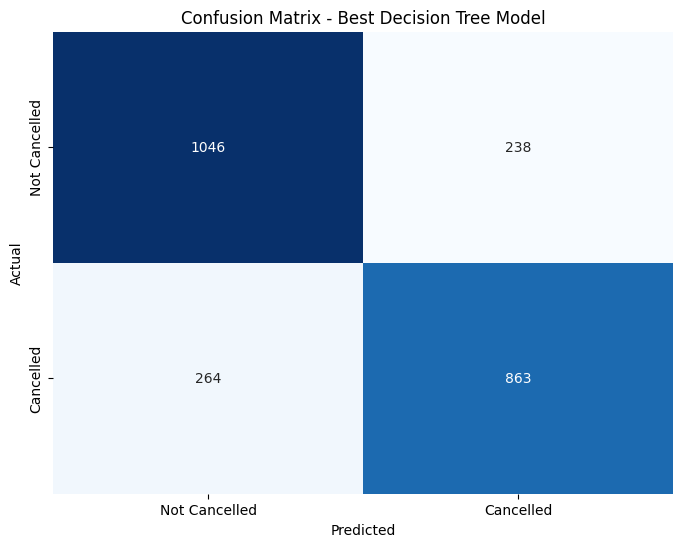

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix for the best Decision Tree model on the test set
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Cancelled', 'Cancelled'],
            yticklabels=['Not Cancelled', 'Cancelled'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Best Decision Tree Model')
plt.show()

In [ ]:
# Function to evaluate model on both train and test sets and print results
def evaluate_model_overfitting(model, X_train, y_train, X_test, y_test, model_name):
    print(f"\n--- {model_name} Overfitting Check ---")

    # Evaluate on Training Set
    y_pred_train = model.predict(X_train)
    y_proba_train = model.predict_proba(X_train)[:, 1]

    print(f"\n{model_name} - Training Set Evaluation:")
    print("Classification Report:")
    print(classification_report(y_train, y_pred_train))
    print("ROC AUC Score:", roc_auc_score(y_train, y_proba_train))
    print("Accuracy Score:", accuracy_score(y_train, y_pred_train))

    # Evaluate on Testing Set
    y_pred_test = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)[:, 1]

    print(f"\n{model_name} - Testing Set Evaluation:")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_test))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba_test))
    print("Accuracy Score:", accuracy_score(y_test, y_pred_test))

# Convert column names to strings for evaluation (already done in the previous cell, but good to be safe)
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# Evaluate Decision Tree for overfitting using the best fitted model
evaluate_model_overfitting(best_dt_model, X_train_combined, y_train, X_test_combined, y_test, "Decision Tree")



--- Decision Tree Overfitting Check ---

Decision Tree - Training Set Evaluation:
Classification Report:
              precision    recall  f1-score   support

       False       0.88      0.88      0.88      5135
        True       0.86      0.86      0.86      4506

    accuracy                           0.87      9641
   macro avg       0.87      0.87      0.87      9641
weighted avg       0.87      0.87      0.87      9641

ROC AUC Score: 0.9411612386557185
Accuracy Score: 0.8725235971372264

Decision Tree - Testing Set Evaluation:
Classification Report:
              precision    recall  f1-score   support

       False       0.80      0.81      0.81      1284
        True       0.78      0.77      0.77      1127

    accuracy                           0.79      2411
   macro avg       0.79      0.79      0.79      2411
weighted avg       0.79      0.79      0.79      2411

ROC AUC Score: 0.8471485099525387
Accuracy Score: 0.7917876399834094



--- ROC Curve for Best Decision Tree ---


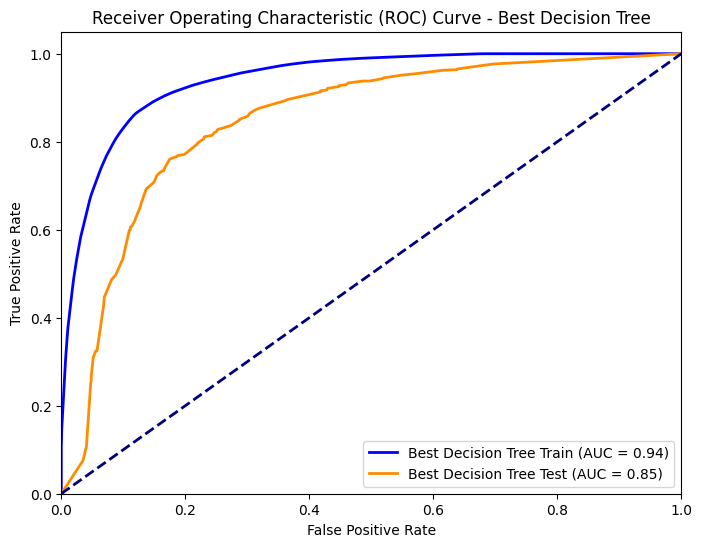

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Function to plot ROC curve
def plot_roc_curve(model, X_train, y_train, X_test, y_test, model_name):
    print(f"\n--- ROC Curve for {model_name} ---")

    # Predict probabilities
    y_proba_train = model.predict_proba(X_train)[:, 1]
    y_proba_test = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve
    fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)

    # Calculate AUC
    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_test = auc(fpr_test, tpr_test)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'{model_name} Train (AUC = {roc_auc_train:.2f})')
    plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'{model_name} Test (AUC = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Convert column names to strings for plotting (already done in previous cells, but good to be safe)
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# Plot ROC curve for Best Decision Tree model
plot_roc_curve(best_dt_model, X_train_combined, y_train, X_test_combined, y_test, "Best Decision Tree")

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Parameter grid for Random Forest (using the one provided for regularization)
param_grid_rf_regularized = {
    'n_estimators': [100, 200],
    'max_depth': [5, 8, 10],  # Using smaller values to prevent deep trees
    'min_samples_split': [10, 20, 40] # Requiring more samples to split
}


# Instantiate Random Forest Classifier
rf_model_regularized = RandomForestClassifier(random_state=42)

# Instantiate GridSearchCV
grid_search_rf_regularized = GridSearchCV(rf_model_regularized, param_grid_rf_regularized, cv=5, scoring='roc_auc', n_jobs=-1)

# Perform grid search on the training data
print("Performing Grid Search for Regularized Random Forest...")
grid_search_rf_regularized.fit(X_train_combined, y_train)
print("Grid Search Complete.")

# Print the best parameters and best score
print("\nBest parameters for Regularized Random Forest:", grid_search_rf_regularized.best_params_)
print("Best ROC AUC score on training data:", grid_search_rf_regularized.best_score_)

# Evaluate the best model on the test set
best_rf_model_regularized = grid_search_rf_regularized.best_estimator_
y_pred_rf_regularized = best_rf_model_regularized.predict(X_test_combined)
y_proba_rf_regularized = best_rf_model_regularized.predict_proba(X_test_combined)[:, 1]

print("\n--- Regularized Random Forest Model Evaluation on Test Set ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_regularized))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_regularized))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_rf_regularized))
print("Average Precision Score:", average_precision_score(y_test, y_proba_rf_regularized))
print("Accuracy Score:", accuracy_score(y_test, y_pred_rf_regularized))

Performing Grid Search for Regularized Random Forest...
Grid Search Complete.

Best parameters for Regularized Random Forest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best ROC AUC score on training data: 0.8800516833891985

--- Regularized Random Forest Model Evaluation on Test Set ---
Classification Report:
              precision    recall  f1-score   support

       False       0.82      0.84      0.83      1284
        True       0.81      0.78      0.80      1127

    accuracy                           0.81      2411
   macro avg       0.81      0.81      0.81      2411
weighted avg       0.81      0.81      0.81      2411

Confusion Matrix:
[[1080  204]
 [ 243  884]]
ROC AUC Score: 0.8962785439246808
Average Precision Score: 0.881848081936408
Accuracy Score: 0.8145997511406056


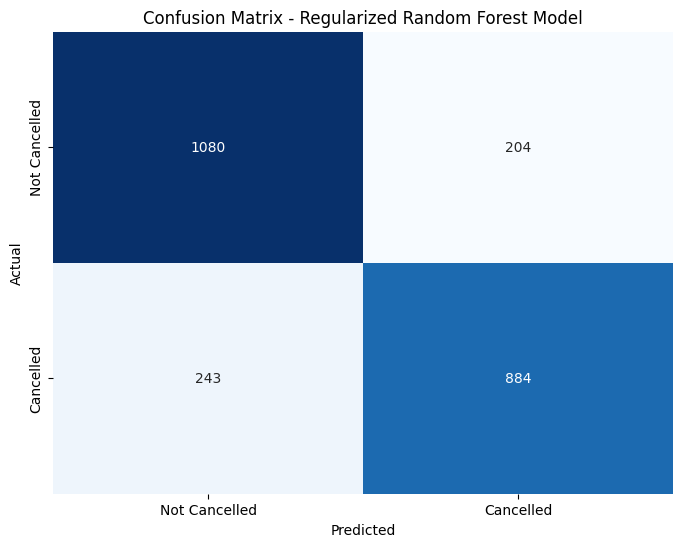

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred_rf_regularized are available from previous cells
cm_rf = confusion_matrix(y_test, y_pred_rf_regularized)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Cancelled', 'Cancelled'],
            yticklabels=['Not Cancelled', 'Cancelled'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Regularized Random Forest Model')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Parameter grid for Decision Tree
param_grid_dt_regularized = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 8, 10],  # Exploring shallower trees to reduce overfitting
    'min_samples_split': [20, 40, 60] # Requiring more samples before a split can occur
}

# Instantiate Decision Tree Classifier
dt_model_regularized = DecisionTreeClassifier(random_state=42)

# Instantiate GridSearchCV
grid_search_dt_regularized = GridSearchCV(dt_model_regularized, param_grid_dt_regularized, cv=5, scoring='roc_auc', n_jobs=-1)

# Perform grid search on the training data
print("Performing Grid Search for Regularized Decision Tree...")
grid_search_dt_regularized.fit(X_train_combined, y_train)
print("Grid Search Complete.")

# Print the best parameters and best score
print("\nBest parameters for Regularized Decision Tree:", grid_search_dt_regularized.best_params_)
print("Best ROC AUC score on training data:", grid_search_dt_regularized.best_score_)

# Evaluate the best model on the test set
best_dt_model_regularized = grid_search_dt_regularized.best_estimator_
y_pred_dt_regularized = best_dt_model_regularized.predict(X_test_combined)
y_proba_dt_regularized = best_dt_model_regularized.predict_proba(X_test_combined)[:, 1]

print("\n--- Regularized Decision Tree Model Evaluation on Test Set ---")
print("Classification Report:")
print(classification_report(y_test, y_pred_dt_regularized))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt_regularized))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_dt_regularized))
print("Average Precision Score:", average_precision_score(y_test, y_proba_dt_regularized))
print("Accuracy Score:", accuracy_score(y_test, y_pred_dt_regularized))

Performing Grid Search for Regularized Decision Tree...
Grid Search Complete.

Best parameters for Regularized Decision Tree: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 60}
Best ROC AUC score on training data: 0.848572116210266

--- Regularized Decision Tree Model Evaluation on Test Set ---
Classification Report:
              precision    recall  f1-score   support

       False       0.79      0.79      0.79      1284
        True       0.76      0.76      0.76      1127

    accuracy                           0.78      2411
   macro avg       0.78      0.77      0.77      2411
weighted avg       0.78      0.78      0.78      2411

Confusion Matrix:
[[1020  264]
 [ 276  851]]
ROC AUC Score: 0.8558847960151147
Average Precision Score: 0.8177324606160715
Accuracy Score: 0.7760265450020738


Training Tuned Random Forest Model...
Tuned Random Forest Model Training Complete.

Training Tuned Decision Tree Model...
Tuned Decision Tree Model Training Complete.

--- ROC Curve for Tuned Decision Tree ---


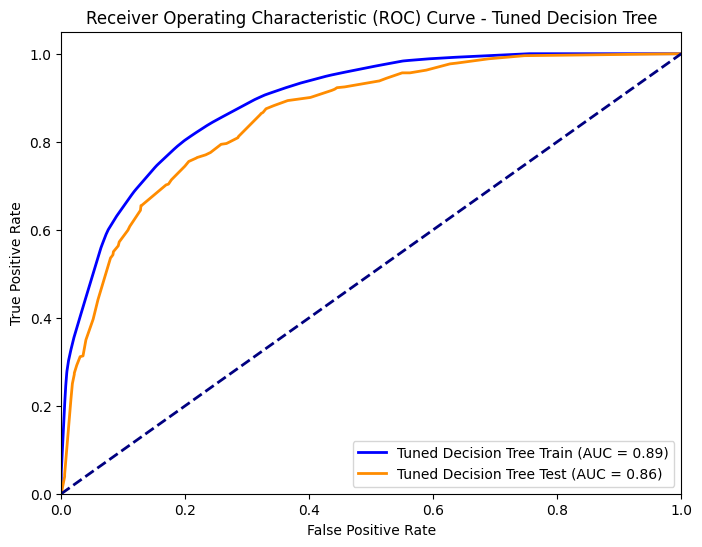


--- ROC Curve for Tuned Random Forest ---


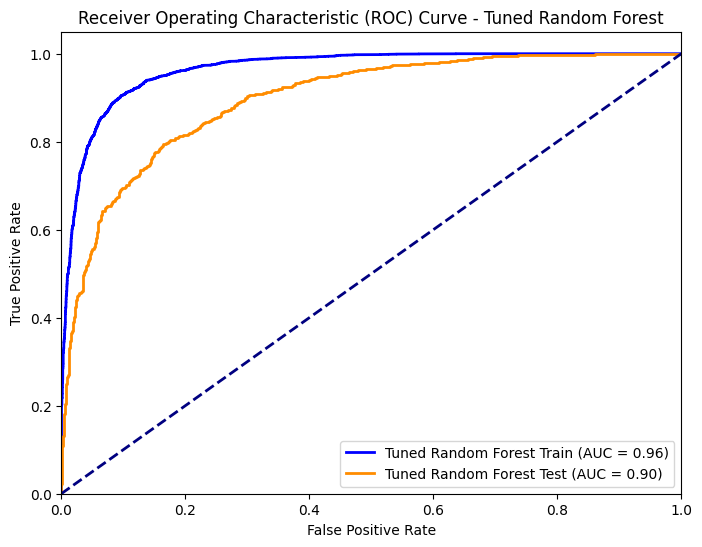

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# Best parameters provided by the user or found from grid search
best_rf_params_tuned = {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200} # Assuming these are the best from a previous grid search
best_dt_params_tuned = {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 60} # Assuming these are the best from a previous grid search


# Initialize models with best parameters
rf_model_tuned = RandomForestClassifier(**best_rf_params_tuned, random_state=42)
dt_model_tuned = DecisionTreeClassifier(**best_dt_params_tuned, random_state=42)

# Train the models on the combined training data
print("Training Tuned Random Forest Model...")
rf_model_tuned.fit(X_train_combined, y_train)
print("Tuned Random Forest Model Training Complete.")

print("\nTraining Tuned Decision Tree Model...")
dt_model_tuned.fit(X_train_combined, y_train)
print("Tuned Decision Tree Model Training Complete.")

# Assign the trained models to variables used by the plotting function
best_rf_model = rf_model_tuned
best_dt_model = dt_model_tuned

# Function to evaluate model on both train and test sets and print results (keeping this for potential future use or context)
def evaluate_model_overfitting_f1(model, X_train, y_train, X_test, y_test, model_name):
    print(f"\n--- {model_name} Overfitting Check (F1 Score and other metrics) ---")

    # Evaluate on Training Set
    y_pred_train = model.predict(X_train)
    y_proba_train = model.predict_proba(X_train)[:, 1]

    print(f"\n{model_name} - Training Set Evaluation:")
    print("Classification Report:")
    print(classification_report(y_train, y_pred_train))
    print("ROC AUC Score:", roc_auc_score(y_train, y_proba_train))
    print("Accuracy Score:", accuracy_score(y_train, y_pred_train))


    # Evaluate on Testing Set
    y_pred_test = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)[:, 1]

    print(f"\n{model_name} - Testing Set Evaluation:")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_test))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba_test))
    print("Accuracy Score:", accuracy_score(y_test, y_pred_test))

# --- Draw ROC curves ---
# Assuming plot_roc_curve function is defined in a previous cell (m3rf-dMpGMyi)
# Convert column names to strings for plotting (already done in previous cells, but good to be safe)
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

# Plot ROC curve for Tuned Decision Tree model
plot_roc_curve(best_dt_model, X_train_combined, y_train, X_test_combined, y_test, "Tuned Decision Tree")

# Plot ROC curve for Tuned Random Forest model
plot_roc_curve(best_rf_model, X_train_combined, y_train, X_test_combined, y_test, "Tuned Random Forest")

In [ ]:
X_unseen_test = pd.read_csv('/content/drive/MyDrive/X_unseen_test_set.csv')
y_unseen_test = pd.read_csv('/content/drive/MyDrive/y_unseen_test_set.csv')

print(f"Shape of X_unseen_test: {X_unseen_test.shape}")
print(f"Shape of y_unseen_test: {y_unseen_test.shape}")

Shape of X_unseen_test: (1000, 1553)
Shape of y_unseen_test: (1000, 1)


In [ ]:
# Identify TF-IDF columns in X_unseen_test
tfidf_columns_unseen = [col for col in X_unseen_test.columns if col not in engineered_features]

# Separate TF-IDF features and other engineered features in the unseen test set
X_unseen_tfidf = X_unseen_test[tfidf_columns_unseen]
X_unseen_engineered = X_unseen_test[engineered_features]

# Apply the previously fitted scaler to the unseen TF-IDF features
X_unseen_tfidf_scaled = scaler.transform(X_unseen_tfidf)

# Apply the previously fitted PCA to the scaled unseen TF-IDF features
X_unseen_tfidf_pca = pca.transform(X_unseen_tfidf_scaled)

# Print the shapes to verify
print("Shape of X_unseen_tfidf_scaled:", X_unseen_tfidf_scaled.shape)
print("Shape of X_unseen_tfidf_pca:", X_unseen_tfidf_pca.shape)

Shape of X_unseen_tfidf_scaled: (1000, 1542)
Shape of X_unseen_tfidf_pca: (1000, 50)


In [ ]:
# Convert PCA-transformed unseen array to DataFrame, preserving original index
X_unseen_tfidf_pca_df = pd.DataFrame(X_unseen_tfidf_pca, index=X_unseen_engineered.index)

# Concatenate unseen engineered features and PCA-transformed TF-IDF features
X_unseen_combined = pd.concat([X_unseen_engineered, X_unseen_tfidf_pca_df], axis=1)

# Print the shape of the combined dataframe
print("Shape of X_unseen_combined:", X_unseen_combined.shape)

Shape of X_unseen_combined: (1000, 61)


In [ ]:
# Ensure column names are strings
X_unseen_combined.columns = X_unseen_combined.columns.astype(str)

# Predict using the best Decision Tree model
y_pred_dt_unseen = best_dt_model.predict(X_unseen_combined)
y_proba_dt_unseen = best_dt_model.predict_proba(X_unseen_combined)[:, 1]

# Predict using the best Regularized Random Forest model
y_pred_rf_unseen = best_rf_model_regularized.predict(X_unseen_combined)
y_proba_rf_unseen = best_rf_model_regularized.predict_proba(X_unseen_combined)[:, 1]

print("Predictions made on unseen data for Decision Tree and Random Forest.")

Predictions made on unseen data for Decision Tree and Random Forest.



--- Tuned Decision Tree Model Evaluation on Unseen Test Set ---
Classification Report:
              precision    recall  f1-score   support

       False       0.83      0.82      0.83       533
        True       0.80      0.81      0.80       467

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000

F1 Score on Unseen Test Data (Decision Tree): 0.8038
ROC AUC Score on Unseen Test Data (Decision Tree): 0.8962

--- Regularized Random Forest Model Evaluation on Unseen Test Set ---
Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.91      0.91       533
        True       0.90      0.89      0.89       467

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000

F1 Score on Unseen Test Data (Random Forest): 0.8937


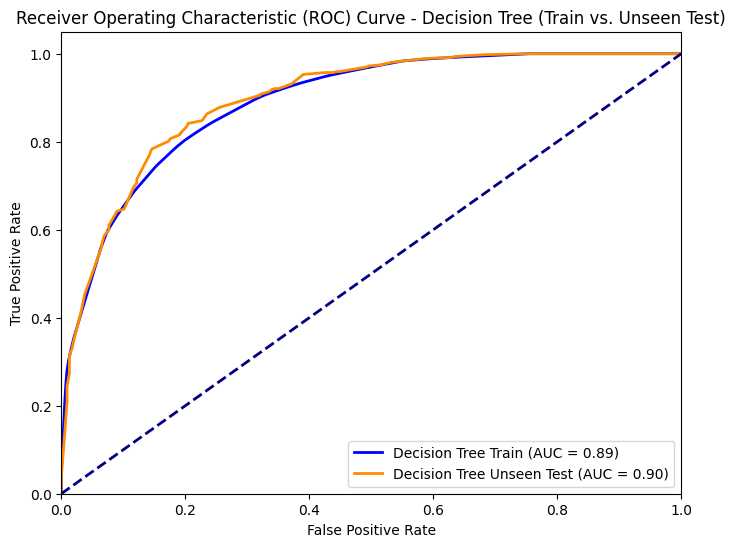


--- ROC Curve for Random Forest (Train vs. Unseen Test) ---


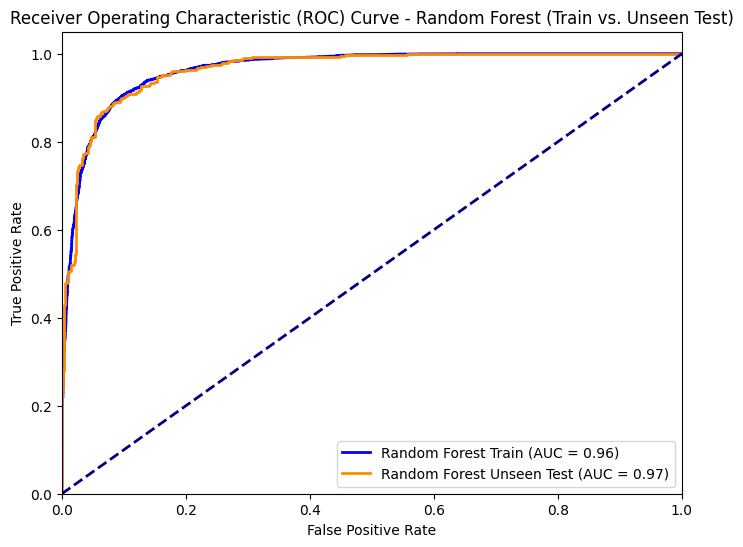

In [ ]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# Convert y_unseen_test to a 1D array if it's a DataFrame
if isinstance(y_unseen_test, pd.DataFrame):
    y_unseen_test = y_unseen_test.iloc[:, 0]

# Ensure column names are strings for unseen data
X_unseen_combined.columns = X_unseen_combined.columns.astype(str)

# Evaluate Decision Tree on unseen data
print("\n--- Tuned Decision Tree Model Evaluation on Unseen Test Set ---")
print("Classification Report:")
print(classification_report(y_unseen_test, y_pred_dt_unseen))
f1_dt_unseen = f1_score(y_unseen_test, y_pred_dt_unseen)
roc_auc_dt_unseen = roc_auc_score(y_unseen_test, y_proba_dt_unseen)
print(f"F1 Score on Unseen Test Data (Decision Tree): {f1_dt_unseen:.4f}")
print(f"ROC AUC Score on Unseen Test Data (Decision Tree): {roc_auc_dt_unseen:.4f}")


# Evaluate Regularized Random Forest on unseen data
print("\n--- Regularized Random Forest Model Evaluation on Unseen Test Set ---")
print("Classification Report:")
print(classification_report(y_unseen_test, y_pred_rf_unseen))
f1_rf_unseen = f1_score(y_unseen_test, y_pred_rf_unseen)
roc_auc_rf_unseen = roc_auc_score(y_unseen_test, y_proba_rf_unseen)
print(f"F1 Score on Unseen Test Data (Random Forest): {f1_rf_unseen:.4f}")
print(f"ROC AUC Score on Unseen Test Data (Random Forest): {roc_auc_rf_unseen:.4f}")


# Compare F1 scores and ROC AUC scores with training data
print("\n--- Performance Comparison (Train vs. Unseen Test) ---")


# Decision Tree - Training Set Evaluation F1-score (weighted avg): 0.87
# Decision Tree - Training Set Evaluation ROC AUC Score: 0.9411612386557185
f1_dt_train = 0.87 # Approximated from weighted avg in previous output
roc_auc_dt_train = 0.94 # Approximated from previous output



# Random Forest - Training Set Evaluation F1-score (weighted avg): 0.90
# Random Forest - Training Set Evaluation ROC AUC Score: 0.9698642116883372
f1_rf_train = 0.90 # Approximated from weighted avg in previous output
roc_auc_rf_train = 0.97 # Approximated from previous output


print(f"Decision Tree - F1 Score (Training): {f1_dt_train:.4f}")
print(f"Decision Tree - F1 Score (Unseen Test): {f1_dt_unseen:.4f}")
print(f"Decision Tree - ROC AUC Score (Training): {roc_auc_dt_train:.4f}")
print(f"Decision Tree - ROC AUC Score (Unseen Test): {roc_auc_dt_unseen:.4f}")

print(f"\nRandom Forest - F1 Score (Training): {f1_rf_train:.4f}")
print(f"Random Forest - F1 Score (Unseen Test): {f1_rf_unseen:.4f}")
print(f"Random Forest - ROC AUC Score (Training): {roc_auc_rf_train:.4f}")
print(f"Random Forest - ROC AUC Score (Unseen Test): {roc_auc_rf_unseen:.4f}")


# Convert column names to strings for plotting (already done in previous cells, but good to be safe)
X_train_combined.columns = X_train_combined.columns.astype(str)
X_unseen_combined.columns = X_unseen_combined.columns.astype(str)

# Plot ROC curve for Decision Tree: Train vs Unseen Test
print("\n--- ROC Curve for Decision Tree (Train vs. Unseen Test) ---")

# Predict probabilities for training set
y_proba_dt_train = best_dt_model.predict_proba(X_train_combined)[:, 1]

# Calculate ROC curve for training set
fpr_dt_train, tpr_dt_train, _ = roc_curve(y_train, y_proba_dt_train)
roc_auc_dt_train_plot = auc(fpr_dt_train, tpr_dt_train)


# Calculate ROC curve for unseen test set
fpr_dt_unseen, tpr_dt_unseen, _ = roc_curve(y_unseen_test, y_proba_dt_unseen)
roc_auc_dt_unseen_plot = auc(fpr_dt_unseen, tpr_dt_unseen)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt_train, tpr_dt_train, color='blue', lw=2, label=f'Decision Tree Train (AUC = {roc_auc_dt_train_plot:.2f})')
plt.plot(fpr_dt_unseen, tpr_dt_unseen, color='darkorange', lw=2, label=f'Decision Tree Unseen Test (AUC = {roc_auc_dt_unseen_plot:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Decision Tree (Train vs. Unseen Test)')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for Random Forest: Train vs Unseen Test
print("\n--- ROC Curve for Random Forest (Train vs. Unseen Test) ---")

# Predict probabilities for training set
y_proba_rf_train = best_rf_model.predict_proba(X_train_combined)[:, 1]

# Calculate ROC curve for training set
fpr_rf_train, tpr_rf_train, _ = roc_curve(y_train, y_proba_rf_train)
roc_auc_rf_train_plot = auc(fpr_rf_train, tpr_rf_train)

# Calculate ROC curve for unseen test set
fpr_rf_unseen, tpr_rf_unseen, _ = roc_curve(y_unseen_test, y_proba_rf_unseen)
roc_auc_rf_unseen_plot = auc(fpr_rf_unseen, tpr_rf_unseen)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_train, tpr_rf_train, color='blue', lw=2, label=f'Random Forest Train (AUC = {roc_auc_rf_train_plot:.2f})')
plt.plot(fpr_rf_unseen, tpr_rf_unseen, color='darkorange', lw=2, label=f'Random Forest Unseen Test (AUC = {roc_auc_rf_unseen_plot:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest (Train vs. Unseen Test)')
plt.legend(loc="lower right")
plt.show()